In [1]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [2]:
from transformers import AutoModelForSequenceClassification, AutoTokenizer

# Load model and tokenizer
model = AutoModelForSequenceClassification.from_pretrained('/content/drive/MyDrive/trained_cryptobert_kk08_model', from_tf=False, local_files_only=True)
tokenizer = AutoTokenizer.from_pretrained('/content/drive/MyDrive/trained_cryptobert_kk08_model', local_files_only=True)


# Example: If you're using a text classification task, you can load the test data like this:
test_texts = ["Your test sentence 1", "Your test sentence 2"]
test_labels = [0, 1]  # Corresponding true labels for your test data

In [5]:
!pip install datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 487.4/487.4 kB 32.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 13.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 183.9/183.9 kB 17.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 14.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 19.2 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.3.0
    Uninstalling fsspec-2025.3.0:
      Successfully uninstalled fsspec-2025.3.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2025.3.0 requires fsspec==2025.3.0, but you have fsspec 2024.12.0 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 which

In [6]:
from datasets import load_dataset

In [7]:
import re

def remove_wallets(text):
    # This is a basic implementation - modify if your original remove_wallets was different
    # Common crypto wallet patterns (like Bitcoin/Ethereum addresses)
    wallet_pattern = r'0x[a-fA-F0-9]{40}|[13][a-km-zA-HJ-NP-Z1-9]{25,34}'
    return re.sub(wallet_pattern, '', text)

# Apply cleaning operations specified to the paper, https://github.com/mikik1234/CryptoBERT-LUKE/blob/main/CODE_Data_Collection.ipynb
def clean_text(text):
    # Remove Asian characters
    text = re.sub(r'[\u4e00-\u9fff]+', '', text)
    # Remove URLs
    text = re.sub(r'http\S+|www\S+', '', text)
    # Remove mentions, hashtags, stock symbols, and forward slashes with content
    text = re.sub(r'[@][A-Za-z0-9_]+|#[A-Za-z0-9_]+|$[A-Za-z0-9_ ]+|/[A-Za-z0-9_ ]+', '', text)
    # Remove RT prefix
    text = re.sub(r'RT : ', '', text)
    # Replace & with 'and'
    text = re.sub(r'&', 'and', text)
    # Handle special characters and quotes
    text = re.sub(r'â€™', '\'', text)
    text = re.sub(r'["&;]', '', text)
    text = re.sub(r'', '', text)  # Zero-width space
    # Remove .X or .x
    text = re.sub(r'\.[Xx]', '', text)
    # Normalize multiple dots to ellipsis
    text = re.sub(r'\.\.+', '...', text)
    # Remove standalone @ and pipe symbols
    text = re.sub(r'@|\|', '', text)
    # Normalize spaces
    text = re.sub(r'\s+', ' ', text).strip()
    # Convert to lowercase
    text = text.lower()
    # Remove wallet addresses
    text = remove_wallets(text)
    text = re.sub(r'^\s*\S+(?:\s+\S+){0,2}\s*$', '', text) # Remove short texts (fewer than 4 words)
    return text

def sentiment_map(text):
  if 'Bullish' in text:
    return 0
  elif 'Neutral' in text:
    return 1
  else:
    return 2


import torch
import numpy as np
import random

# Set random seeds for reproducibility
seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# Create a generator for the split
generator = torch.Generator().manual_seed(seed)






data = load_dataset("StephanAkkerman/financial-tweets-crypto")
train_dataset_ori = data['train']


print(f'No. of data: {len(train_dataset_ori)}')
train_dataset_ori = train_dataset_ori.filter(lambda data: data['sentiment'] is not None)
print(f'No. of data after remove sentiment equals to none: {len(train_dataset_ori)}')
train_dataset_ori = train_dataset_ori.filter(lambda data: data['tweet_type']!='quote tweet')
print(f'No. of data after remove quote tweet: {len(train_dataset_ori)}')
train_dataset_ori = train_dataset_ori.filter(lambda data: len(data['description'].split(' '))>1)
print(f'No. of data after remove short text: {len(train_dataset_ori)}')
train_dataset_ori = train_dataset_ori.to_pandas()
train_dataset_ori['description'] = train_dataset_ori['description'].apply(clean_text)
train_dataset_ori.drop_duplicates(inplace=True, ignore_index=True)
print(f'No. of data after remove duplicates: {len(train_dataset_ori)}') # Make sure the records here remains the same after remove duplicates, else the following train test split might be different
train_dataset_ori['sentiment_label'] = train_dataset_ori['sentiment'].apply(sentiment_map)

# train_dataset_ori = train_dataset_ori.iloc[:1000]


num_samples = len(train_dataset_ori)
# Create an array of indices
indices = np.arange(num_samples)

# Shuffle the indices randomly
np.random.seed(42)  # Set a seed for reproducibility
np.random.shuffle(indices)

# Split the indices into train, validation, and test sets
train_size = int(num_samples * 0.8)  # 80% for training
val_size = int(num_samples * 0.1)  # 10% for validation
test_size = num_samples - train_size - val_size  # 10% for testing

# Split the shuffled indices
train_idx = indices[:train_size]
val_idx = indices[train_size:train_size + val_size]
test_idx = indices[train_size + val_size:]

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/1.19k [00:00<?, ?B/s]

crypto.csv:   0%|          | 0.00/54.9M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/57935 [00:00<?, ? examples/s]

No. of data: 57935


Filter:   0%|          | 0/57935 [00:00<?, ? examples/s]

No. of data after remove sentiment equals to none: 48692


Filter:   0%|          | 0/48692 [00:00<?, ? examples/s]

No. of data after remove quote tweet: 46866


Filter:   0%|          | 0/46866 [00:00<?, ? examples/s]

No. of data after remove short text: 45567
No. of data after remove duplicates: 45567


In [8]:
# Prepare train, validation, and test datasets for further use

# Your dataset splitting process is complete, now let's focus on the test set
test_dataset = train_dataset_ori.loc[test_idx]

# Extract test texts and labels
test_texts = test_dataset['description'].tolist()  # Extract text for testing
test_labels = test_dataset['sentiment_label'].tolist()  # Extract labels for testing

# Tokenize the test texts
encodings = tokenizer(test_texts, truncation=True, padding=True, max_length=512)

# Convert to tensors
inputs = torch.tensor(encodings['input_ids'])
attention_mask = torch.tensor(encodings['attention_mask'])

# Make predictions with the model
with torch.no_grad():
    outputs = model(input_ids=inputs, attention_mask=attention_mask)
    logits = outputs.logits

# Get predictions (class with the highest logit)
predictions = torch.argmax(logits, dim=-1)

# Print the first 5 predictions with true labels
for i in range(5):  # Print the first 5 predictions
    print(f"Text: {test_texts[i]}")
    print(f"True Label: {test_labels[i]}, Predicted Label: {predictions[i].item()}")

Text: good coin > []( > $mtl looks good for a long back towards yearly open. just waiting on trigger.
True Label: 0, Predicted Label: 0
Text: after that daily im fairly confident the 5 wave rise from the lows is now complete anticipating a multi mnth pullback to around 19k where absolutely everyone gets chopped to little tiny pieces and wishes they stopped trading will happily load up long term longs sub 20k
True Label: 0, Predicted Label: 0
Text: $btc: the 200 ema on the 4h has acted as support, i expect this to continue.
True Label: 0, Predicted Label: 0
Text: live in 15 minutes! > []( > join me live at 10pm gmt for for ledges live youtube stream in partnership with > > > > visit and receive up to $7000 trading bonus on your deposit with trader1sz promo code
True Label: 1, Predicted Label: 1
Text: live in 5 minutes! > []( > join me live in 1 hour for ' for ledges' live stream in partnership with > > > > visit and receive up to $7000 trading bonus on your deposit with trader1sz promo 

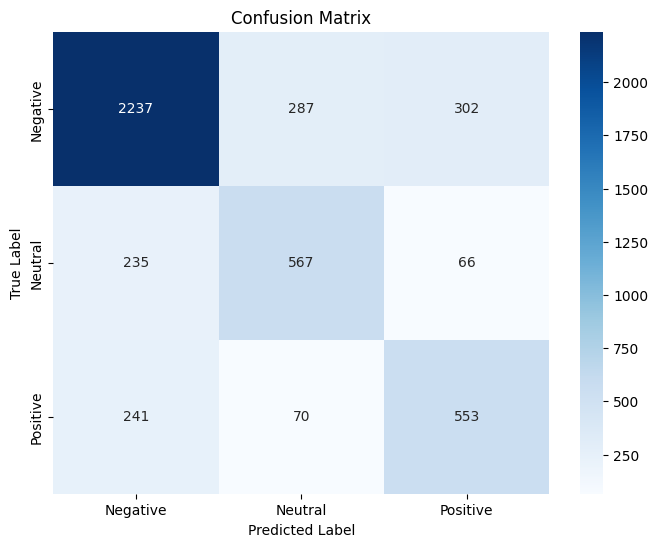

In [10]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Compute confusion matrix
cm = confusion_matrix(test_labels, predictions)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Negative", "Neutral", "Positive"], yticklabels=["Negative", "Neutral", "Positive"])
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

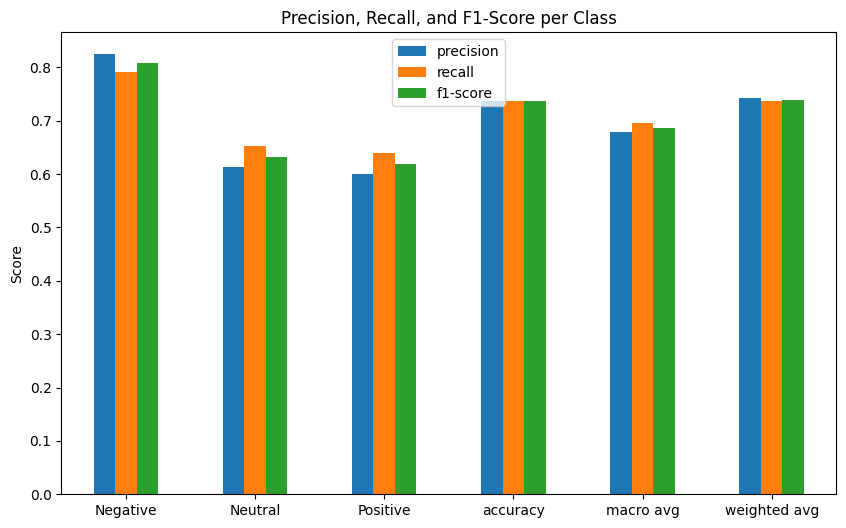

In [11]:
from sklearn.metrics import classification_report

# Get classification report (precision, recall, f1 per class)
report = classification_report(test_labels, predictions, target_names=["Negative", "Neutral", "Positive"], output_dict=True)

# Create DataFrame for better presentation
import pandas as pd
report_df = pd.DataFrame(report).transpose()

# Plot precision, recall, F1 score per class
report_df.drop(columns=["support"]).plot(kind="bar", figsize=(10, 6))
plt.title("Precision, Recall, and F1-Score per Class")
plt.ylabel("Score")
plt.xticks(rotation=0)
plt.show()

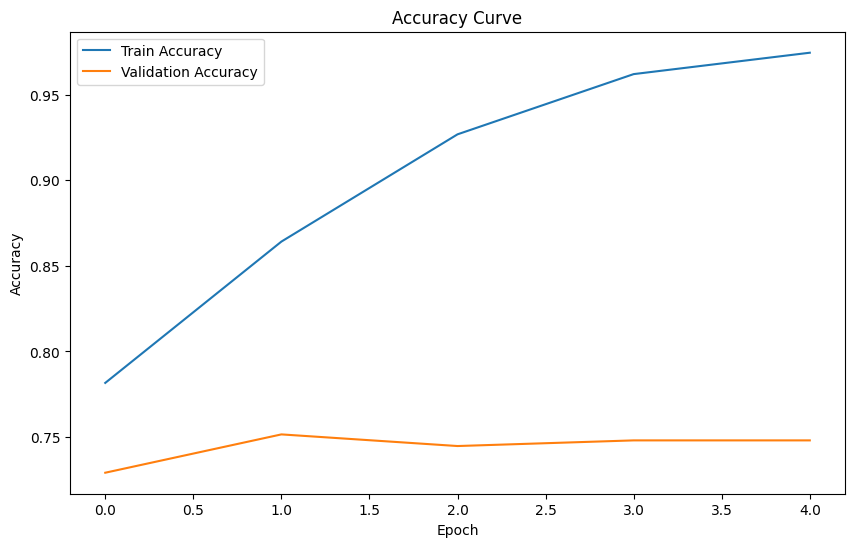

In [14]:
import matplotlib.pyplot as plt

# Extract training and validation accuracy from trainer logs
train_accuracies = [.7816, .8642, .9269, .9621, .9746]
eval_accuracies = [.7291, .7515, .7447, .7480, .7480]

# Plot a single figure
plt.figure(figsize=(10, 6))

# Accuracy plot
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(eval_accuracies, label='Validation Accuracy')
plt.title("Accuracy Curve")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()

# Show the plot
plt.show()

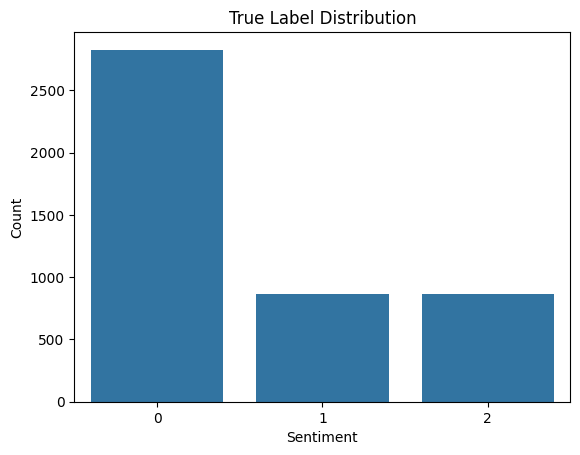

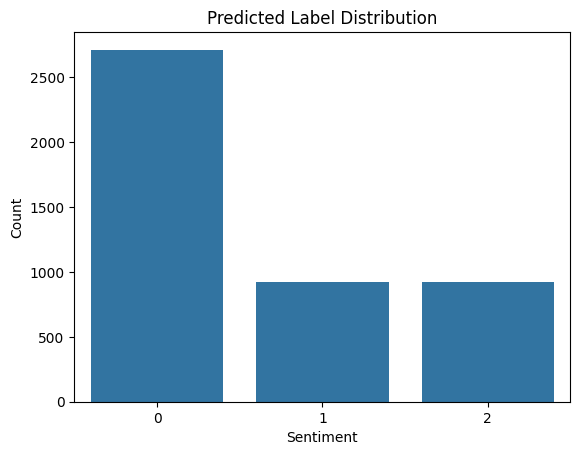

In [13]:
# Plot class distribution of the dataset and predictions
import seaborn as sns

# Actual class distribution
sns.countplot(x=test_labels)
plt.title("True Label Distribution")
plt.xlabel("Sentiment")
plt.ylabel("Count")
plt.show()

# Predicted class distribution
sns.countplot(x=predictions)
plt.title("Predicted Label Distribution")
plt.xlabel("Sentiment")
plt.ylabel("Count")
plt.show()